### Project members : 
 EL-AJJOURI Safaa
 
 BOUTAHAR Mohammed

# Sentiment Analysis

## All what you need to install

In [ ]:
!pip install -U imbalanced-learn
!pip install spacy
!python -m spacy download en_core_web_sm

## All what you need to import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import string
import nltk 
import string
from nltk.corpus import stopwords
import spacy
from tqdm.auto import tqdm
import time

## Import the dataset

In [2]:
data = pd.read_csv("sub_reviews_hotels.csv", sep=';', on_bad_lines="skip", encoding='ISO-8859-1')

In [4]:
data.head(10)

,Review,Rating
0,mice room husband stayed museum hotel month st...,1
1,was there for wobi conference across the stree...,1
2,bad far outweighs good understand china expect...,1
3,terible experience birthday stayed hotel liana...,1
4,do yourself a huge favor and do not stay here ...,1
5,naploleon nightmare called hotel directly make...,1
6,regrettable i do not recommend it for anything...,1
7,myself and my family stayed here at the end of...,1
8,i am writing in regard of our stay earlier in ...,1
9,not family environment booked hotel travelocit...,1


In [5]:
data.tail()

,Review,Rating
21495,love the new yorker hotel and especially their...,5
21496,i recommend this hotel to everyone booked thro...,5
21497,i stayed with my daughter in dec 2018 for a se...,5
21498,clean hotel room was lovely beds comfy reasona...,5
21499,the hilton hotel was fantasticmyself and a fri...,5


## Evaluating the dataset

### Handling Null Values

In [226]:
data.isna().any()

Review    False
Rating    False
dtype: bool

In [227]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

### Useful information

In [3]:
data.shape

(21500, 2)

In [8]:
review_counts = data.groupby('Rating').size()

# Print the count of reviews for each rating
print(review_counts)

Rating
1    4300
2    4300
3    4300
4    4300
5    4300
dtype: int64


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21500 entries, 0 to 21499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  21500 non-null  object
 1   Rating  21500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 336.1+ KB


### In case you want to sub divide the dataset into sub-sets of the same shape

In [222]:
for rating in range(1, 6):
    # Filter the DataFrame to get only the reviews with the current rating
    rating_df = data[data['Rating'] == rating]
    
    # Sample 4300 reviews from the filtered DataFrame and add them to the sampled DataFrame
    sub_data = pd.DataFrame(rating_df.sample(n=4300, random_state=42))

    # Write the DataFrame to a CSV file
    sub_data.to_csv(f'sub_data_{rating}.csv', sep=';', index=False)
print("Success")

                                                  Review Rating
36990  mice room husband stayed museum hotel month st...      1
10533  was there for wobi conference across the stree...      1
35693  bad far outweighs good understand china expect...      1
36360  terible experience birthday stayed hotel liana...      1
15140  do yourself a huge favor and do not stay here ...      1
...                                                  ...    ...
26408  the hotel is well located on 8th avenue a shor...      1
36402  hotel mithila mithila hotel not recommended re...      1
32672  ive used premier inns for business for many ye...      1
7653   i got a nice please check in email from hilton...      1
18300  let me start from the top the young bell boy w...      1

[4300 rows x 2 columns]
                                                  Review Rating
37775  needs improvement having stayed hotel 4 nights...      2
37210  medium yes place mixed reviews depending revie...      2
29985  small ro

## Preprocessing the Text

In [3]:
# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
nlp

### Lemmatization

In [234]:
def preprocess_text(text):
    # Parse the text with Spacy
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stop words
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join the lemmas back into a string and return it
    return " ".join(lemmas)

In [235]:
%%time

tqdm.pandas()

data['Review'] = data['Review'].progress_apply(preprocess_text)

  0%|          | 0/21500 [00:00<?, ?it/s]

Wall time: 3min 50s


### Remove unwanted information

In [5]:
def remove_URL (text):
    url = re.compile(r"https?://\s+ www\.\s+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)
         

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" # emoticons
        u"\U0001F300-\U0001F5FF" # symbols & pictographs
        u"\U0001F680-\U0001F6FF" # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" # flags (i0s)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)


def remove_punct (text):
    table = str.maketrans ("","",string.punctuation)
    return text.translate(table)

stop = set (stopwords.words ( "english"))
def remove_stopwords (text):
    text = [word.lower () for word in text.split() if word.lower() not in stop]
    return " ".join (text)

In [6]:
def cleanDataframe(df):
    Review_cleaned = df.Review.map(lambda x: remove_URL(x))
    Review_cleaned = Review_cleaned.map(lambda x: remove_html(x))
    Review_cleaned = Review_cleaned.map(lambda x: remove_emoji(x))
    Review_cleaned = Review_cleaned.map(lambda x: remove_punct(x)) 
    Review_cleaned = Review_cleaned.map(remove_stopwords)   
    return Review_cleaned

In [53]:
#comparison of cleaned data and raw data
df=[]
df = data.copy()
df.insert(1, "Review_cleaned", cleanDataframe(data))
df

,Review,Review_cleaned,Rating
0,mice room husband stayed museum hotel month st...,mice room husband stayed museum hotel month st...,1
1,was there for wobi conference across the stree...,wobi conference across street lincoln center d...,1
2,bad far outweighs good understand china expect...,bad far outweighs good understand china expect...,1
3,terible experience birthday stayed hotel liana...,terible experience birthday stayed hotel liana...,1
4,do yourself a huge favor and do not stay here ...,huge favor stay dont even know begin vast majo...,1
...,...,...,...
21495,love the new yorker hotel and especially their...,love new yorker hotel especially staff employe...,5
21496,i recommend this hotel to everyone booked thro...,recommend hotel everyone booked lastminutecom ...,5
21497,i stayed with my daughter in dec 2018 for a se...,stayed daughter dec 2018 second time course st...,5
21498,clean hotel room was lovely beds comfy reasona...,clean hotel room lovely beds comfy reasonably ...,5


In [7]:
#data cleaning
data.Review = cleanDataframe(data)
data

,Review,Rating
0,mice room husband stayed museum hotel month st...,1
1,wobi conference across street lincoln center d...,1
2,bad far outweighs good understand china expect...,1
3,terible experience birthday stayed hotel liana...,1
4,huge favor stay dont even know begin vast majo...,1
...,...,...
21495,love new yorker hotel especially staff employe...,5
21496,recommend hotel everyone booked lastminutecom ...,5
21497,stayed daughter dec 2018 second time course st...,5
21498,clean hotel room lovely beds comfy reasonably ...,5


## Commonly Used Words

In [56]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(data['Review'].values)

In [57]:
# Split the text into individual words
words = all_text.split()

In [58]:
# Count the frequency of each word
word_counts = Counter(words)

In [59]:
top_words = word_counts.most_common(50)
top_words

[('room', 29772),
 ('hotel', 29257),
 ('staff', 10833),
 ('stay', 10036),
 ('rooms', 9220),
 ('great', 8932),
 ('good', 8140),
 ('location', 7982),
 ('clean', 6578),
 ('stayed', 6475),
 ('night', 6248),
 ('nice', 6121),
 ('would', 5757),
 ('service', 5696),
 ('time', 5692),
 ('small', 5611),
 ('us', 5228),
 ('like', 4982),
 ('day', 4975),
 ('one', 4940),
 ('desk', 4702),
 ('bathroom', 4605),
 ('bed', 4469),
 ('place', 4283),
 ('really', 4252),
 ('new', 4152),
 ('friendly', 4108),
 ('get', 4028),
 ('breakfast', 3915),
 ('floor', 3904),
 ('nt', 3880),
 ('got', 3769),
 ('2', 3435),
 ('walk', 3399),
 ('helpful', 3368),
 ('check', 3277),
 ('also', 3212),
 ('people', 3203),
 ('food', 3171),
 ('could', 3108),
 ('told', 3092),
 ('front', 3064),
 ('shower', 3035),
 ('water', 2973),
 ('nights', 2962),
 ('booked', 2917),
 ('lobby', 2892),
 ('view', 2860),
 ('area', 2824),
 ('even', 2802)]

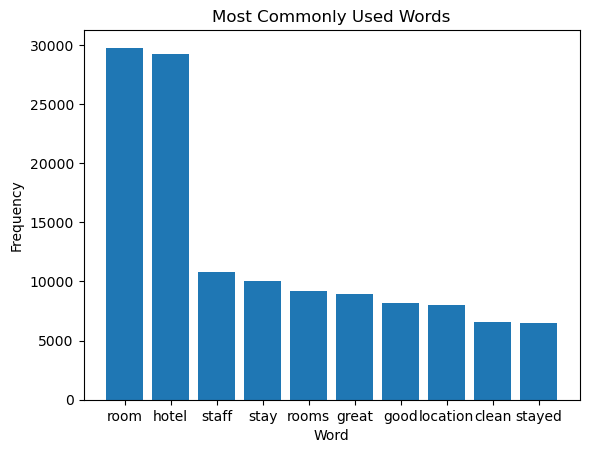

In [60]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

### Note:
It wasn't really important to remove some frequently used words like 'room' and 'hotel' since models already handel that situation by ignoring words that are used in all classes

## Converting Text into Numerical Features / Vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Review'])
y = data['Rating']

## Class Distributions

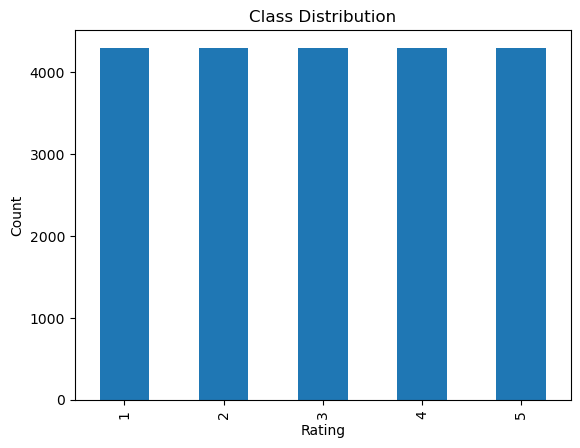

In [64]:
# Count the number of instances in each class
class_counts = data['Rating'].value_counts()
class_counts.plot.bar()
plt.title('Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Machine Learning Models

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

In [10]:
def cross_validation(model, X, y, folds):
    # Define your cross-validation strategy
    cv = KFold(n_splits=folds, shuffle=True, random_state=42)
    
    accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    accuracies = pd.Series(accuracies)
    print("Accuracy : min=", accuracies.min()*100, "%  max=", accuracies.max()*100, "%  mean=", accuracies.mean()*100, "%")

    precisions = cross_val_score(model, X, y, cv=cv, scoring='precision_macro')
    print("Precisions : min=", precisions.min()*100, "%  max=",precisions.max()*100, "%  mean=", precisions.mean()*100, "%")
    
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
    print("F1_score : min=", f1_scores.min()*100, "%  max=",f1_scores.max()*100, "%  mean=",f1_scores.mean())
    
    y_pred = cross_val_predict(model, X, y, cv=cv)

    cm = confusion_matrix(y, y_pred)

    cm_display = ConfusionMatrixDisplay(cm).plot()


## Support Vector Machines

In [11]:
from sklearn import svm

# train an SVM model
svmModel = svm.SVC(kernel='linear')

svmModel

SVC(kernel='linear')

### Cross-Validation approach

In [13]:
cross_validation(svmModel, X, y, 5)

Accuracy : min= 56.74418604651162 %  max= 58.93023255813954 %  mean= 58.069767441860456 %
Precisions : min= 56.68222890133505 %  max= 58.96934402267815 %  mean= 58.135864278562366 %
F1_score : min= 56.60409889100464 %  max= 58.93377752893934 %  mean= 0.5803084404760577


NameError: name 'cross_val_predict' is not defined

### Hold-Out approach 

In [12]:
svmModel.fit(X_train, y_train)

SVC(kernel='linear')

In [13]:
y_pred = svmModel.predict(X_test)
y_pred

array([5, 3, 4, ..., 1, 4, 4], dtype=int64)

Accuracy: 58.651162790697676 %
precision score: 58.725426707264546 %
f1score: 58.68054035755883 %
[[601 184  49   4   4]
 [244 432 162  27   7]
 [ 89 128 454 162  28]
 [ 11  30 218 443 183]
 [  6  11  32 199 592]]


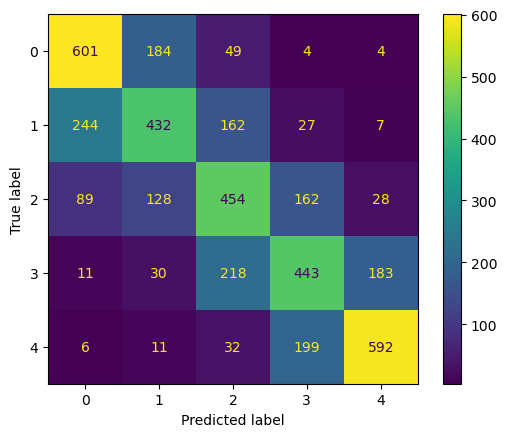

In [14]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1score:", f1*100, "%")
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## Multinomial Naive Bayes Model

In [71]:
from sklearn.naive_bayes import MultinomialNB
# train a Naive Bayes classifier
mnb = MultinomialNB()

In [72]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [13]:
# evaluate the classifier on the test set
y_pred = mnb.predict(X_test)
y_pred

array([4, 3, 4, ..., 3, 3, 4], dtype=int64)

Accuracy: 58.395348837209305 %
f1score: 58.7704362913961 %
[[538 208  90   4   2]
 [200 424 212  28   8]
 [ 73  90 468 211  19]
 [ 14  23 194 514 140]
 [  6   5  23 239 567]]


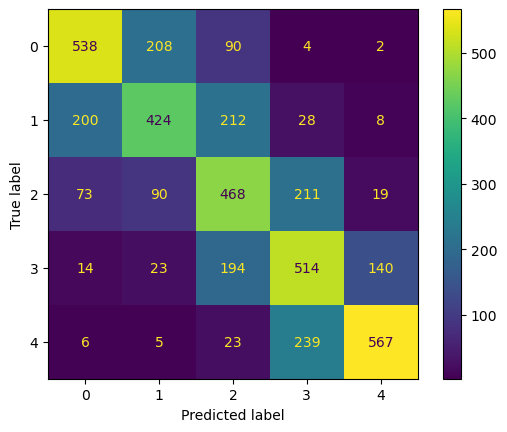

In [15]:
acc_naivebayes = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1score:", f1*100, "%")
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [87]:
cross_validation(mnb, X, y, 50)

Accuracy : min= 50.93023255813953 %  max= 63.0232558139535 %  mean= 56.81860465116277 %
Precisions : min= 52.59074333134887 %  max= 63.97685902448861 %  mean= 58.363154018571564 %
F1_score : min= 51.425358113517184 %  max= 62.56974210587429 %  mean= 0.5707338289520523


## Decision Tree

In [15]:
from sklearn import tree

In [16]:
dtc = tree.DecisionTreeClassifier()

In [17]:
%%time
dtc.fit(X_train, y_train)

Wall time: 9.02 s


DecisionTreeClassifier()

In [18]:
# evaluate the classifier on the test set
y_pred = dtc.predict(X_test)

In [265]:
y_pred

array([3, 4, 5, ..., 4, 3, 3], dtype=int64)

In [22]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1 score:", f1*100, "%")
print(confusion_matrix(y_test, y_pred))

Accuracy: 41.651162790697676 %
precision score: 41.49670731773796 %
f1 score: 41.608605531733396 %
[[467 215  93  38  29]
 [254 328 137  86  67]
 [115 145 283 193 125]
 [ 53  76 229 306 221]
 [ 39  55 120 219 407]]


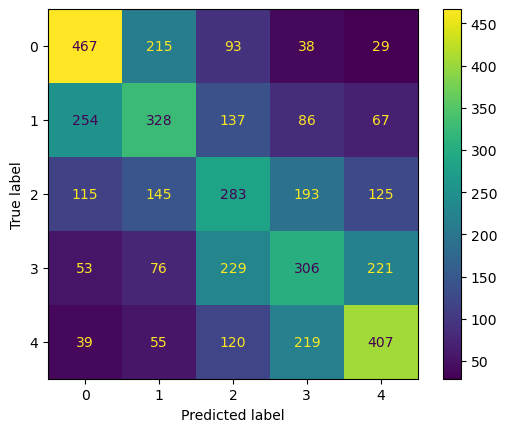

In [20]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [32]:
cross_validation(dtc, X, y)

Accuracy : min= 0.39325581395348835   max= 0.4211627906976744   moyenne= 0.41162790697674423
Precisions : min= 0.8836130835473422   max= 0.8836130835473422   moyenne= 0.8836130835473422
F1_score : min= 0.8836298440904896   max= 0.8836298440904896   moyenne= 0.8836298440904896


## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rfc = RandomForestClassifier(random_state=0)

In [17]:
%%time
rfc.fit(X_train, y_train)

Wall time: 40.4 s


RandomForestClassifier(random_state=0)

In [18]:
# evaluate the classifier on the test set
y_pred = rfc.predict(X_test)

In [19]:
y_pred

array([5, 3, 4, ..., 1, 4, 5], dtype=int64)

In [21]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1 score:", f1*100, "%")
print(confusion_matrix(y_test, y_pred))

Accuracy: 54.81395348837209 %
precision score: 54.75676209481304 %
f1 score: 53.6706758693 %
[[658 114  44  11  15]
 [350 300 145  38  39]
 [145  66 386 193  71]
 [ 39  22 172 384 268]
 [ 19   5  25 162 629]]


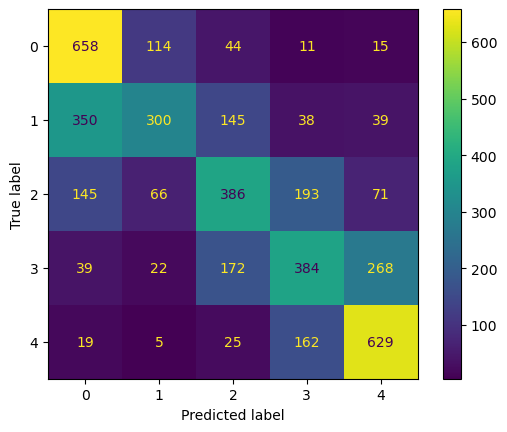

In [22]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
#Affichage résumé des entrainements de modèles
summary = pd.DataFrame(columns=['File Name','Size','Category 1','Category 2','Category 3','Category 4','Category 5','Lemmatization',''])